# Clustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
from sklearn import metrics     
import plotly.figure_factory as ff

import seaborn as sns # For data visualization and specifically for pairplot()
import matplotlib.pyplot as plt # For data visualization

from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from sklearn.metrics import silhouette_score   # For Hyperparameter Tuning
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

## Utility functions

In [ ]:
"""
scale the dataframe
args:
    - dataframe (DataFrame): dataframe to scale
    - scaler (Scaler, default: StandardScaler): scaler used to scale the dataframe data.
returns:
    - scaled dataframe
"""
def scale(dataframe, scaler = StandardScaler()):
    scaler.fit(dataframe)
    return scaler.transform(dataframe)

### Kmeans Functions

In [ ]:


"""
apply kmeans to a dataframe 
args:
    - dataframe (DataFrame): dataframe we want to clusterize
    - n_cluster (int, default: 2): number of cluster the algorithm will produce
    - n_init (int, default: 5): number of initialization of kmeans
returns:
    - the result of kmeans
""" 

def kmeans(dataframe, n_cluster=2, n_init=5, scaler=StandardScaler()):
    km = KMeans(n_clusters=n_cluster, n_init=n_init)
    km.fit(dataframe)
    return km

"""
Returns array A s.t. A[i] is the silhouette score for kmeans using k=i and n_init=n_init
args:
    - s_dataframe (DataFrame): scaled dataframe over which apply kmeans
    - min_max_k (range): range of ks to try
    - n_init(optional, default: 2): number of initialization of kmeans 
returns: 
    dictionary with the following structure: {k: [list of used k], silhouette_scores: [silhouette scores], inertia_scores: [inerti scores]}, 
                                                i.e.: {k:[2,3], silhouette_scores:[0.43, 0.32], inertia_scores:[1.21, 2.11]}
"""
def compute_scores_kmean(s_dataframe, min_max_k, n_init=2):
    used_k = []
    silhouette_scores = []
    inertia_scores = []

    for k in min_max_k:
        model_kmeans_k = kmeans(s_dataframe, n_cluster=k, n_init=n_init)
        labels_k = model_kmeans_k.labels_
        score_k = metrics.silhouette_score(s_dataframe, labels_k)
        used_k.append(k)
        silhouette_scores.append(score_k)
        inertia_scores.append(model_kmeans_k.inertia_)
        #print("Tested kMeans with k = %d\tSS: %5.4f" % (k, score_k))
    
    return {'k': used_k, 'silhouette_scores': silhouette_scores, 'inertia_scores': inertia_scores}

"""
prints the chart that shows how silhouette_scores evolves with k. The closer to 1 it is, the better it is.
args:
    silhouette_scores (dictionary): result obtained by find_best_k function
"""
def plot_silhouette_scores(silhouette_scores):
    fig = px.line(silhouette_scores, x="k", y="silhouette_scores")
    fig.show()

"""
prints the chart that shows how inertia_scores evolves with k. The higher it is, the better it is.
args:
    inertia_scores (dictionary): result obtained by find_best_k function
"""
def plot_inertia_scores(inertia_scores):
    fig = px.line(inertia_scores, x="k", y="inertia_scores")
    fig.show()
 

example of usage:

In [ ]:
"""
df = df_male_winner_stats_top
scaled_df = scale(df)

scores = compute_scores_kmean(scaled_df, range(2,30), 3)
plot_silhouette_scores(scores)
plot_inertia_scores(scores)
"""

'\ndf = df_male_winner_stats_top\nscaled_df = scale(df)\n\nscores = compute_scores_kmean(scaled_df, range(2,30), 3)\nplot_silhouette_scores(scores)\nplot_inertia_scores(scores)\n'

### DBScan 

In [ ]:
"""
apply dbscan to the given dataframe
args:
    - dataframe (DataFrame): dataframe we want to clusterize
    - eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.
returns:
    the result of dbscan
"""
def exec_dbscan(dataframe, eps, min_samples):
    dbscan = DBSCAN( eps = eps, min_samples = min_samples)
    return dbscan.fit(dataframe)


"""
to find optimal epsilon we calculate the distance from each point to its closest neighbour using the NearestNeighbors
args:
    - dataframe
returns array of distances
"""
def get_distances(dataframe, k=3):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(dataframe)
    distances, indices = nbrs.kneighbors(dataframe)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return distances 
    

"""
perform grid search to find best min_sample value according to silhouette scores
"""
def dbscan_grid_search(dataframe, min_samples_range, eps=0.2):
    min_samples_tried = []
    silhouette_scores = []
    for min_samples in min_samples_range:
        dbscan_result = exec_dbscan(dataframe, eps, min_samples)
        min_samples_tried.append(min_samples)
        silhouette_scores.append(metrics.silhouette_score(dataframe, dbscan_result.labels_))
    return {'min_samples': min_samples_tried, 'silhouette_scores': silhouette_scores}

"""
prints the chart that shows how silhouette_scores evolves with min samples. The closer to 1 it is, the better it is.
args:
    silhouette_scores (dictionary): result obtained by find_best_k function
"""
def plot_silhouette_scores_dbscan(silhouette_scores):
    fig = px.line(silhouette_scores, x="min_samples", y="silhouette_scores")
    fig.show()

        

### Hierarchical Clustering

In [ ]:
"""
"""
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

"""
"""
def grid_search_hierarchical(dataframe, threshold_range):
    silhouette_scores = []
    thresholds = []

    for threshold in threshold_range:
        clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold, linkage='complete').fit(dataframe)
        silhouette_scores.append(metrics.silhouette_score(dataframe, clustering.labels_))
        thresholds.append(threshold)
        
    return {'thresholds': thresholds, 'silhouette_scores': silhouette_scores}

"""
prints the chart that shows how silhouette_scores evolves with threshold. The closer to 1 it is, the better it is.
args:
    silhouette_scores (dictionary): result obtained by find_best_k function
"""
def plot_silhouette_scores_hierarchical(silhouette_scores):
    fig = px.line(silhouette_scores, x="thresholds", y="silhouette_scores")
    fig.show()


#  Clustering on the dataset matches_*_players

In [ ]:
matches_male_players = pd.read_csv("../data/integrations/matches_male_players.csv")
matches_female_players = pd.read_csv("../data/integrations/matches_female_players.csv")

In [ ]:
df_male_matches = matches_male_players[['Won_Tournaments', 'Number_of_Matches', 'Win_Percentage']]
df_female_matches = matches_female_players[['Won_Tournaments', 'Number_of_Matches', 'Win_Percentage']]

### Kmean 

#### Male players

In [ ]:
df_male_matches_scaled = scale(df_male_matches)
result = compute_scores_kmean(df_male_matches_scaled, range(2,30), 5)
plot_silhouette_scores(result)
plot_inertia_scores(result)

NameError: name 'scale' is not defined

try with K=2 

In [ ]:
km = kmeans(df_male_matches_scaled, n_cluster=2)
labels = km.labels_
df_male_matches_scaled = pd.DataFrame(df_male_matches_scaled)
df_male_matches_scaled["cluster"] = labels 

px.scatter_3d(df_male_matches_scaled, x=0, y=1, z=2, color='cluster')

try with K=5

In [ ]:
km = kmeans(df_male_matches_scaled, n_cluster=5, n_init=30)
labels = km.labels_
df_male_matches_scaled = pd.DataFrame(df_male_matches_scaled)
df_male_matches_scaled["cluster"] = labels 

px.scatter_3d(df_male_matches_scaled, x=0, y=1, z=2, color='cluster')

#### Female players

In [ ]:
df_female_matches_scaled = scale(df_female_matches)
result = compute_scores_kmean(df_female_matches_scaled, range(2,30), 5)
plot_silhouette_scores(result)
plot_inertia_scores(result)

try with K = 2

In [ ]:
km = kmeans(df_female_matches_scaled, n_cluster=2)
labels = km.labels_
df_female_matches_scaled = pd.DataFrame(df_female_matches_scaled)
df_female_matches_scaled["cluster"] = labels 

px.scatter_3d(df_female_matches_scaled, x=0, y=1, z=2, color='cluster')

K=4

In [ ]:
km = kmeans(df_female_matches_scaled, n_cluster=4)
labels = km.labels_
df_female_matches_scaled = pd.DataFrame(df_female_matches_scaled)
df_female_matches_scaled["cluster"] = labels 

px.scatter_3d(df_female_matches_scaled, x=0, y=1, z=2, color='cluster')

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



## DBSCAN

#### Man player

In [ ]:
df_male_matches_scaled = scale(df_male_matches)
distances = get_distances(df_male_matches_scaled)
px.line(distances)


In [ ]:
#min_samples = 30
min_samples_to_test = range(2, 100, 2)
s = dbscan_grid_search(df_male_matches_scaled, min_samples_to_test, 0.35)
plot_silhouette_scores_dbscan(s)

In [ ]:
dbscan_result = exec_dbscan(df_male_matches_scaled, eps=0.3, min_samples= 30)
labels = dbscan_result.labels_
df_male_matches_scaled = pd.DataFrame(df_male_matches_scaled)
df_male_matches_scaled["cluster"] = labels 

#df_male_matches_tmp["cluster"] = labels 


px.scatter_3d(df_male_matches_scaled, x=0, y=1, z=2, color='cluster')
#px.scatter(df_male_matches_tmp, color='cluster')

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



#### Female player

In [ ]:
df_female_matches_scaled = scale(df_female_matches)
distances = get_distances(df_female_matches_scaled)
px.line(distances)
#ε=0.2

In [ ]:
#min_samples = 30
min_samples_to_test = range(5, 150, 5)
s = dbscan_grid_search(df_female_matches_scaled, min_samples_to_test)
plot_silhouette_scores_dbscan(s)

NameError: name 'df_female_matches_scaled' is not defined

In [ ]:
dbscan_result = exec_dbscan(df_female_matches_scaled, eps=0.2, min_samples=30)
labels = dbscan_result.labels_
df_female_matches_scaled = pd.DataFrame(df_female_matches_scaled)
df_female_matches_scaled["cluster"] = labels 

px.scatter_3d(df_female_matches_scaled, x=0, y=1, z=2, color='cluster')

## Hierarchical clustering

#### Male player

In [ ]:
df_male_matches_scaled = scale(df_male_matches)

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='complete').fit(df_male_matches_scaled)
labels = clustering.labels_
df_male_matches_scaled = pd.DataFrame(df_male_matches_scaled)
df_male_matches_scaled["cluster"] = labels 

px.scatter_3d(df_male_matches_scaled, x=0, y=1, z=2, color='cluster')

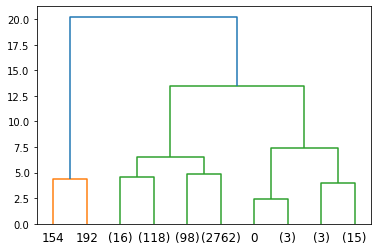

In [ ]:
plot_dendrogram(clustering, truncate_mode="level", p=3)

In [ ]:
result = grid_search_hierarchical(df_male_matches_scaled, np.arange(0.1, 15.0, 0.1))
plot_silhouette_scores_hierarchical(result)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1677: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/shared-libs/python3.7/py/lib/python3.7/site

#### Female player

In [ ]:
df_female_matches_scaled = scale(df_female_matches)

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='complete').fit(df_female_matches_scaled)
labels = clustering.labels_
df_female_matches_scaled = pd.DataFrame(df_female_matches_scaled)
df_female_matches_scaled["cluster"] = labels 

px.scatter_3d(df_female_matches_scaled, x=0, y=1, z=2, color='cluster')

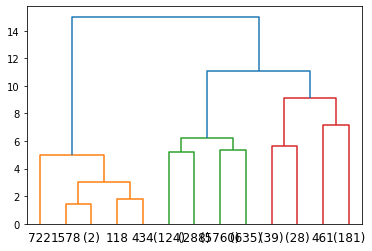

In [ ]:
plot_dendrogram(clustering, truncate_mode="level", p=3)

# Clustering player match statistics

In [ ]:
df_player_match_statistics_original = pd.read_csv("../data/integrations/player_match_statistics.csv")
df_player_match_statistics = df_player_match_statistics_original.drop(columns=['Name', 'Unnamed: 0'])

### kmeans

In [ ]:
df_statistics_scaled = scale(df_player_match_statistics)
result = compute_scores_kmean(df_statistics_scaled, range(2,30), 5)
plot_silhouette_scores(result)
plot_inertia_scores(result)

In [ ]:
km = kmeans(df_statistics_scaled, n_cluster=3)
labels = km.labels_
df_statistics_scaled_col = pd.DataFrame(df_player_match_statistics, columns = df_player_match_statistics.columns)
df_statistics_scaled_col["cluster"] = labels 

fig = px.scatter_matrix(df_statistics_scaled_col, color='cluster')
fig.show()

### DBSCAN

In [ ]:
df_player_match_statistics_scaled = scale(df_player_match_statistics)
distances = get_distances(df_player_match_statistics_scaled)
px.line(distances)

# ~=0.6

In [ ]:
#min_samples = 30 #ε=0.6
min_samples_to_test = range(5, 150, 5)
s = dbscan_grid_search(df_player_match_statistics_scaled, min_samples_to_test, 0.6)
plot_silhouette_scores_dbscan(s)

In [ ]:
dbscan_result = exec_dbscan(df_player_match_statistics_scaled, eps=0.6, min_samples=15)
labels = dbscan_result.labels_
df_player_match_statistics_scaled_col = pd.DataFrame(df_player_match_statistics_scaled, columns = df_player_match_statistics.columns)
df_player_match_statistics_scaled_col["cluster"] = labels 

fig = px.scatter_matrix(df_player_match_statistics_scaled_col, color='cluster')
fig.show()

### Hierarchical

In [ ]:
df_player_match_statistics_scaled = scale(df_player_match_statistics)

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='complete').fit(df_player_match_statistics_scaled)
labels = clustering.labels_
df_player_match_statistics_scaled_col = pd.DataFrame(df_player_match_statistics, columns = df_player_match_statistics.columns)
df_player_match_statistics_scaled_col["cluster"] = labels 

fig = px.scatter_matrix(df_player_match_statistics_scaled_col, color='cluster')
fig.show()

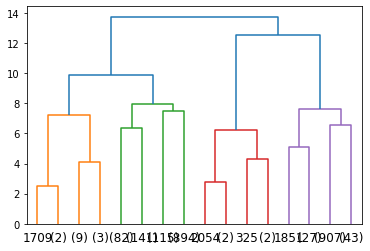

In [ ]:
plot_dendrogram(clustering, truncate_mode="level", p=3)

In [ ]:
df_player_match_statistics_scaled_col['name'] = df_player_match_statistics_original['Name']

df_player_match_statistics_scaled_col[df_player_match_statistics_scaled_col['cluster'] == 0]

ace_percent  break_point      fspw  average_rank  cluster  \
0        0.034551     0.546371  0.645863    500.761905        0   
2        0.032609     0.500000  0.519231    380.000000        0   
4        0.040140     0.564485  0.659364    278.266667        0   
5        0.049798     0.632184  0.646104    294.323232        0   
7        0.054367     0.603659  0.682186    784.619048        0   
...           ...          ...       ...           ...      ...   
2219     0.018868     0.647059  0.581081    222.666667        0   
2221     0.036668     0.590420  0.633651    151.733945        0   
2222     0.052064     0.592834  0.683106    530.380000        0   
2227     0.034943     0.545205  0.670293    707.431034        0   
2229     0.066339     0.481481  0.730290    355.888889        0   

                    name  
0     Gonzalo Villanueva  
2         Filipe Brandao  
4         Nicolas Kicker  
5       Kimberly Birrell  
7        Sho Shimabukuro  
...                  ...  
2219       David Fleming  
2221        Petra Martic  
2222         Sem Verbeek  
2227      Andres Molteni  
2229  Thomas Statzberger  

[1247 rows x 6 columns]

In [ ]:
df_player_match_statistics_scaled_col[df_player_match_statistics_scaled_col['name'] == 'Rafael Nadal']

ace_percent  break_point      fspw  average_rank  cluster          name
1723     0.059136     0.587372  0.687147     44.312102        1  Rafael Nadal

# Clustering tourney_statistics

In [ ]:
df_tourney_stats_original = pd.read_csv("../data/integrations/tourney_statistics.csv")
df_tourney_stats = df_tourney_stats_original.drop(columns=['tourney_name', 'tourney_id', 'Unnamed: 0', 'level_0', 'index'])

In [ ]:
df_tourney_stats

avg_spect    avg_rank  avg_revenue  tot_match
0        2366.0  129.734694    449800.02         49
1        2773.0  180.406250    563339.81         48
2         447.0  104.125000     87559.10         16
3        3921.0  155.983051    560824.91         59
4        3420.0  107.662791    660259.04         43
...         ...         ...          ...        ...
4053     2366.0  117.794872    449800.02         39
4054     2773.0  134.230769    563339.81         39
4055     3199.0  136.282051    763471.28         39
4056     2462.0   93.576923    487848.44         39
4057     3199.0  131.759615    763471.28         52

[4058 rows x 4 columns]

In [ ]:
df_tourney_statistics_scaled = scale(df_tourney_stats)

In [ ]:
result = compute_scores_kmean(df_tourney_statistics_scaled, range(2,30), 5)
plot_silhouette_scores(result)
plot_inertia_scores(result)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
km = kmeans(df_tourney_statistics_scaled, n_cluster=3)
labels = km.labels_
df_tourney_statistics_scaled_col = pd.DataFrame(tourney_stats, columns = tourney_stats.columns)
df_tourney_statistics_scaled_col["cluster"] = labels 

fig = px.scatter_matrix(df_tourney_statistics_scaled_col, color='cluster')
fig.show()

### DBSCAN

In [ ]:
distances = get_distances(df_tourney_statistics_scaled)
px.line(distances)

# ~=0.3

In [ ]:
#min_samples = 30 #ε=0.3
min_samples_to_test = range(5, 50, 5)
s = dbscan_grid_search(df_tourney_statistics_scaled, min_samples_to_test, 0.3)
plot_silhouette_scores_dbscan(s)

In [ ]:
dbscan_result = exec_dbscan(df_tourney_statistics_scaled, eps=0.45, min_samples=30)
labels = dbscan_result.labels_
df_tourney_statistics_scaled_col = pd.DataFrame(df_tourney_stats, columns = df_tourney_stats.columns)
df_tourney_statistics_scaled_col["cluster"] = labels 

fig = px.scatter_matrix(df_tourney_statistics_scaled_col, color='cluster')
fig.show()

In [ ]:
df_tourney_statistics_scaled_col['name'] = df_tourney_stats_original['tourney_name']

df_tourney_statistics_scaled_col[df_tourney_statistics_scaled_col['name'] == 'Australian Open']

avg_spect    avg_rank  avg_revenue  tot_match  cluster             name
131     4727.0  488.016129   1021341.27         31       -1  Australian Open

### Hierarchical

In [ ]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=70, linkage='ward').fit(df_tourney_statistics_scaled)
labels = clustering.labels_
df_tourney_statistics_scaled_col = pd.DataFrame(df_tourney_stats, columns = df_tourney_stats.columns)
df_tourney_statistics_scaled_col["cluster"] = labels 

fig = px.scatter_matrix(df_tourney_statistics_scaled_col, color='cluster')
fig.show()

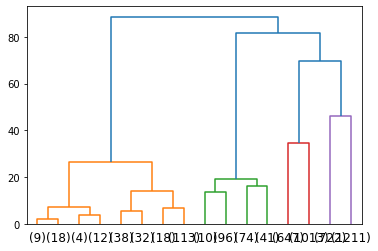

In [ ]:
plot_dendrogram(clustering, truncate_mode="level", p=3)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de87b132-0371-4d99-94f9-c61923e2507d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>